In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def pagerank(M, d: float = 0.85):
    """PageRank algorithm with explicit number of iterations. Returns ranking of nodes (pages) in the adjacency matrix.

    Parameters
    ----------
    M : numpy array
        adjacency matrix where M_i,j represents the link from 'j' to 'i', such that for all 'j'
        sum(i, M_i,j) = 1
    d : float, optional
        damping factor, by default 0.85

    Returns
    -------
    numpy array
        a vector of ranks such that v_i is the i-th rank from [0, 1],
    
    source: https://en.wikipedia.org/wiki/PageRank
    """
    N = M.shape[1]
    w = np.ones(N) / N
    M_hat = d * M
    v = M_hat @ w + (1 - d)
    while(np.linalg.norm(w - v) >= 1e-10):
        w = v
        v = M_hat @ w + (1 - d)
    return v

In [77]:
team_index = ["FKB Power Cats Düdingen", "Genève Volley", "Raiffeisen Volley Glaronia", "Raiffeisen Volley Toggenburg", "Sm'Aesch Pfeffingen", "VBC Cheseaux", "VC Kanti Schaffhausen", "Viteos NUC", "Volley Lugano", "Volleyball Academy"]
df = pd.read_csv("results_nla_women.csv")
df['Date'] = pd.to_datetime(df["Date"], format='%d.%m.%Y')
playoff_start = "2024-03-02"

df_regular_season = df[df["Date"] < playoff_start]
df_playoff = df[df["Date"] >= playoff_start]
results_matrix = np.zeros((len(team_index), len(team_index)))


In [76]:
# Funktion zur Überprüfung des Siegers
def check_winner(row):
    score = row['Score']
    team_a_score, team_b_score = map(int, score.split(':'))
    team_a_index = team_index.index(row['TeamA'])
    team_b_index = team_index.index(row['TeamB'])
    
    if team_a_score > team_b_score:
        if team_b_score < 2:
            results_matrix[team_a_index][team_b_index] += 3
        else:
            results_matrix[team_a_index][team_b_index] += 2
            results_matrix[team_b_index][team_a_index] += 1
    else:
        if team_a_score < 2:
            results_matrix[team_b_index][team_a_index] += 3
        else:
            results_matrix[team_b_index][team_a_index] += 2
            results_matrix[team_a_index][team_b_index] += 1

In [78]:
df_regular_season.apply(check_winner, axis=1)

# Normalise the columns
col_sums = results_matrix.sum(axis=0)
for i, col_sum in enumerate(col_sums):
    if col_sum != 0:
        results_matrix[:, i] /= col_sum

v = pagerank(results_matrix)

for name, score in zip(team_index, v):
    rounded_score = format(score, ".4f")
    print(f"{name}: {rounded_score}")


FKB Power Cats Düdingen: 1.2296
Genève Volley: 0.9578
Raiffeisen Volley Glaronia: 0.6803
Raiffeisen Volley Toggenburg: 0.3742
Sm'Aesch Pfeffingen: 1.2390
VBC Cheseaux: 0.9498
VC Kanti Schaffhausen: 1.3953
Viteos NUC: 1.4944
Volley Lugano: 0.8034
Volleyball Academy: 0.8763


In [81]:
# Prediction
def prediction(row, p, v, s):
    score = row['Score']
    team_a_score, team_b_score = map(int, score.split(':'))
    team_a_index = team_index.index(row['TeamA'])
    team_b_index = team_index.index(row['TeamB'])

    p[0] += 1
    p[1] += (team_a_score > team_b_score) == (v[team_a_index] > v[team_b_index])
    p[2] += (team_a_score > team_b_score) == (s[team_a_index] < s[team_b_index])
    
    


standings = [3,6,8,9,2,7,4,1,5,10]

predict = np.zeros(3)
for index, row in df_playoff.iterrows():
    prediction(row, predict, v, standings)

accuracy_pagerank = 100 * predict[1] / predict[0]
accuracy_standings = 100 * predict[2] / predict[0]

In [83]:
accuracy_standings

66.66666666666667

Below: Split the Season for each into week to get a Page Rank Flow Chart :)

In [84]:
df['Date'] = pd.to_datetime(df["Date"], format='%d.%m.%Y')
weeks = ["2023-10-01","2023-10-08", "2023-10-15", "2023-10-22", "2023-10-29", "2023-11-05", "2023-11-12", "2023-11-19", "2023-11-26", 
         "2023-12-03", "2023-12-10", "2023-12-17", "2023-12-24", "2024-01-07", "2024-01-14", "2024-01-21", "2024-02-04", "2024-02-18", "2024-02-25"]
pagerank_partial = np.zeros((len(weeks), len(team_index)))



for index, w in enumerate(weeks):
    df_partial = df[df["Date"] <= w]
    results_matrix = np.zeros((len(team_index), len(team_index)))
    df_partial.apply(check_winner, axis=1)

    # Normalise the columns
    col_sums = results_matrix.sum(axis=0)
    for i, col_sum in enumerate(col_sums):
        if col_sum != 0:
            results_matrix[:, i] /= col_sum


    v_partial  = pagerank(results_matrix)

    
    pagerank_partial[index] = v_partial




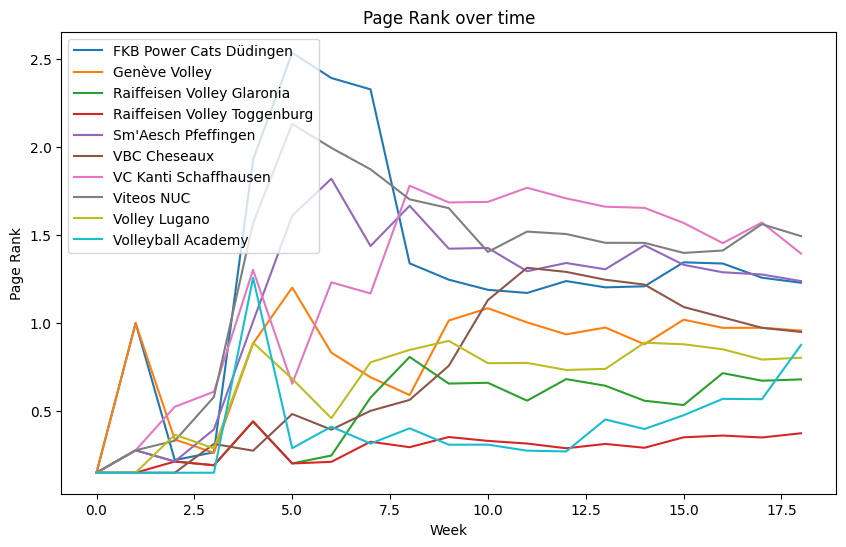

In [85]:
plt.figure(figsize=(10, 6))
for index, team in enumerate(team_index):
    plt.plot(pagerank_partial[:, index], label=team)

plt.title('Page Rank over time')
plt.xlabel('Week')
plt.ylabel('Page Rank')
plt.legend()
plt.show()